In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
%matplotlib inline
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1  
	# split into standard weeks
	train, test = data[0:len(data)], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out):
	# define parameters
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
	# define model

	model = Sequential()
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='linear'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 


In [5]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


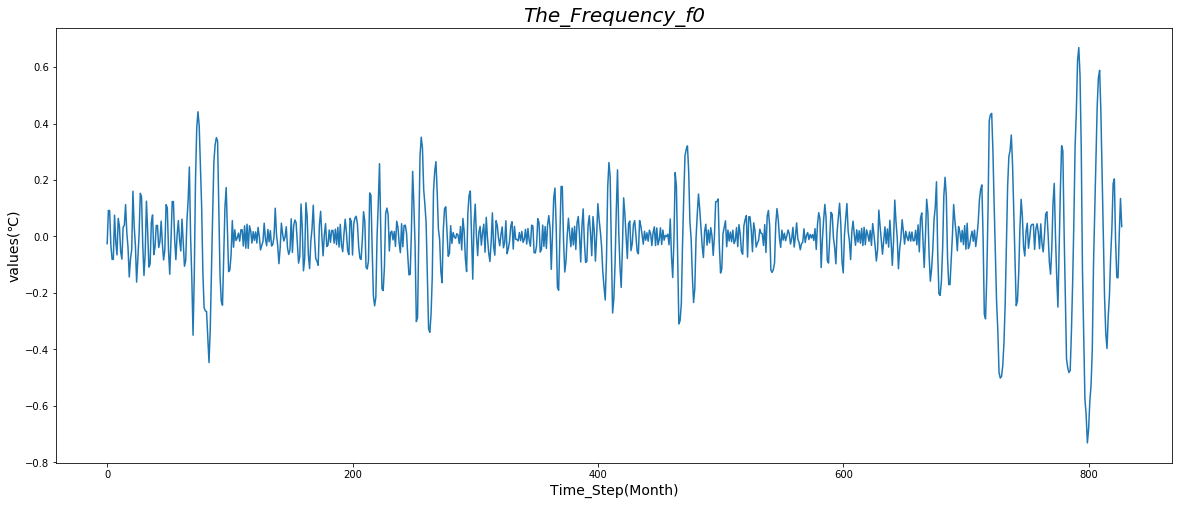

(1, 12, 1)
[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
(804, 12, 1)
(804, 12)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 3s - loss: 0.0194
Epoch 2/200
 - 1s - loss: 0.0175
Epoch 3/200
 - 1s - loss: 0.0169
Epoch 4/200
 - 1s - loss: 0.0172
Epoch 5/200
 - 1s - loss: 0.0165
Epoch 6/200
 - 1s - loss: 0.0165
Epoch 7/200
 - 1s - loss: 0.0163
Epoch 8/200
 - 1s - loss: 0.0163
Epoch 9/200
 - 1s - loss: 0.0163
Epoch 10/200
 - 1s - loss: 0.0161
Epoch 11/200
 - 1s - loss: 0.0162
Epoch 12/200
 - 1s - loss: 0.0165
Epoch 13/200
 - 1s - loss: 0.0161
Epoch 14/200
 - 1s - loss: 0.0157
Epoch 15/200
 - 1s - loss: 0.0156
Epoch 16/200
 - 1s - loss: 0.0157
Epoch 17/200
 - 1s - loss: 0.0157
Epoch 18/200
 - 1s - loss: 0.

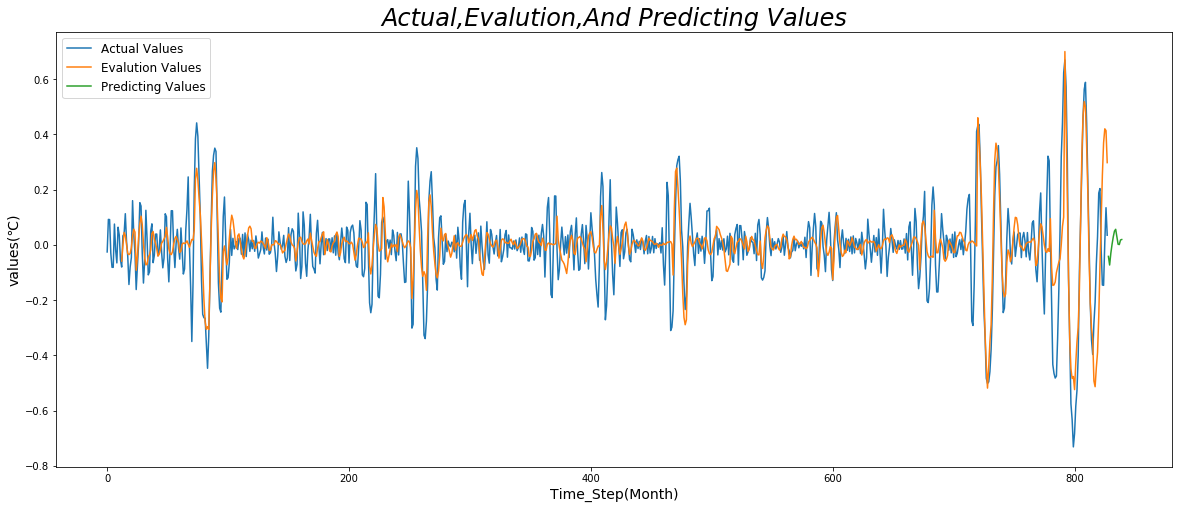

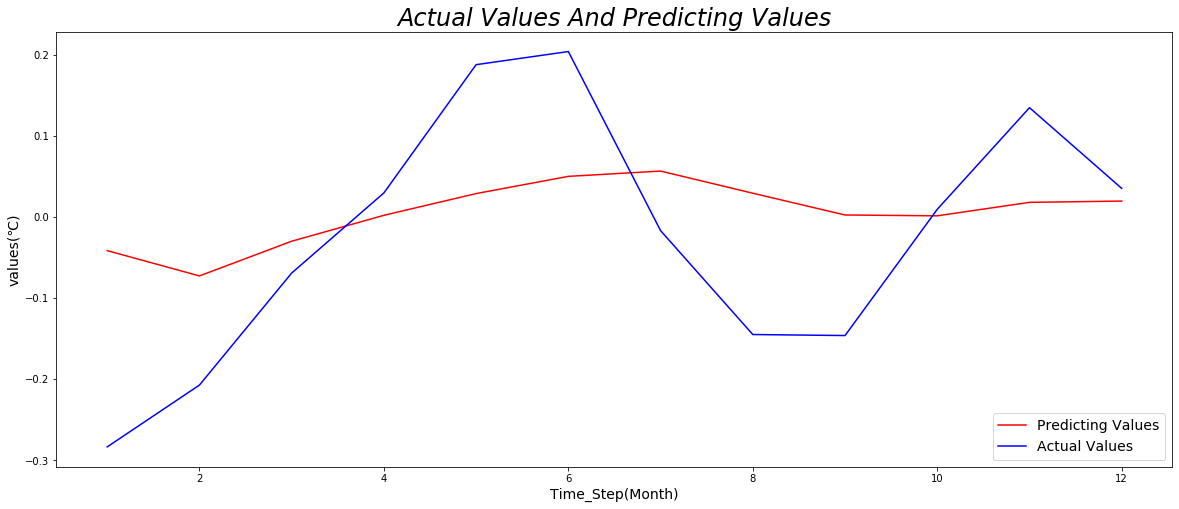

(828,)


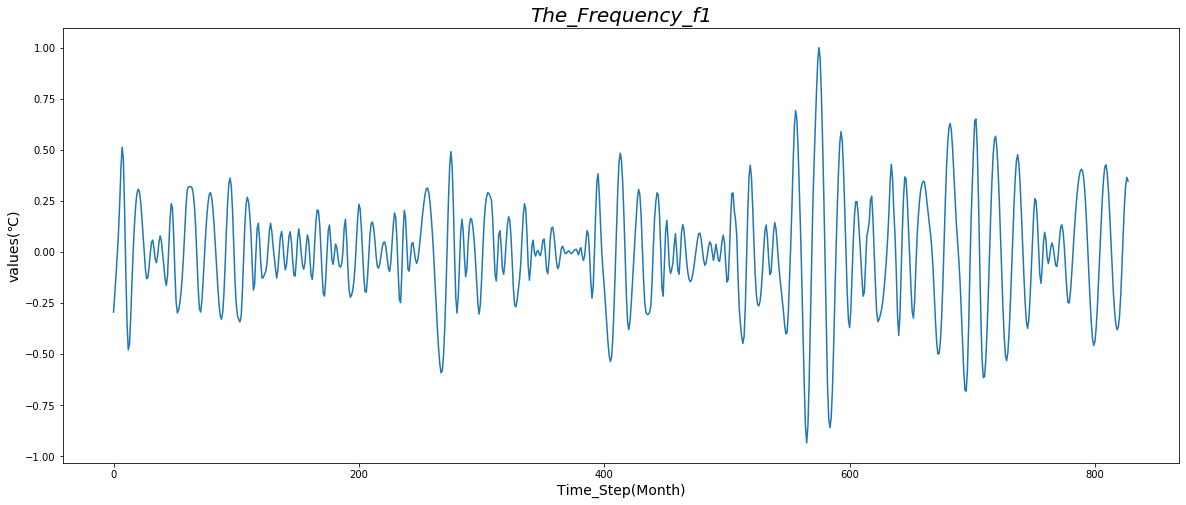

(1, 12, 1)
[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 4s - loss: 0.0487
Epoch 2/200
 - 1s - loss: 0.0376
Epoch 3/200
 - 1s - loss: 0.0353
Epoch 4/200
 - 1s - loss: 0.0344
Epoch 5/200
 - 1s - loss: 0.0336
Epoch 6/200
 - 1s - loss: 0.0328
Epoch 7/200
 - 1s - loss: 0.0330
Epoch 8/200
 - 1s - loss: 0.0318
Epoch 9/200
 - 2s - loss: 0.0324
Epoch 10/200
 - 3s - loss: 0.0319
Epoch 11/200
 - 1s - loss: 0.0323
Epoch 12/200
 - 1s - loss: 0.0306
Epoch 13/200
 - 1s - loss: 0.0312
Epoch 14/200
 - 1s - loss: 0.0305
Epoch 15/200
 - 1s - loss: 0.0305
Epoch 16/200
 - 1s - loss: 0.0306
Epoch 17/200
 - 1s - loss: 0.0308
Epoch 18/200
 - 1s - loss: 0.0304
Epoch 19/200
 - 1s - loss: 0.0310
Epoch 20/200
 - 1s - loss: 0.0309
Epoch 21/200
 - 1s - loss: 0.0310
Epoch 22/200
 - 1s - loss: 0.0311
Epoch 23/200
 - 1s - loss: 0.0308
Epoch 24/200
 - 1s - loss: 0.0297
Epoch 25/200
 - 1s - loss: 0.0296
Ep

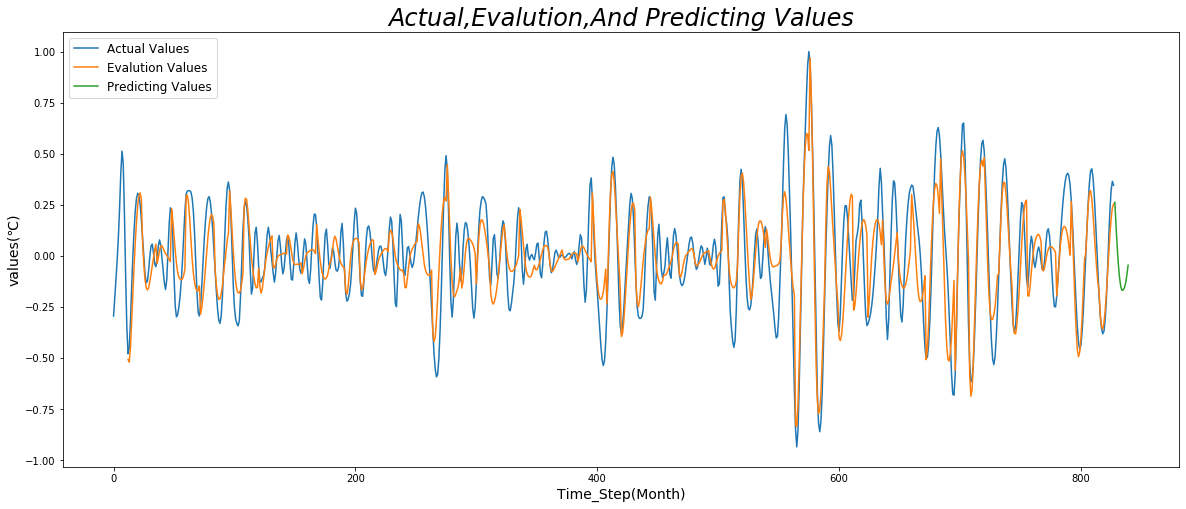

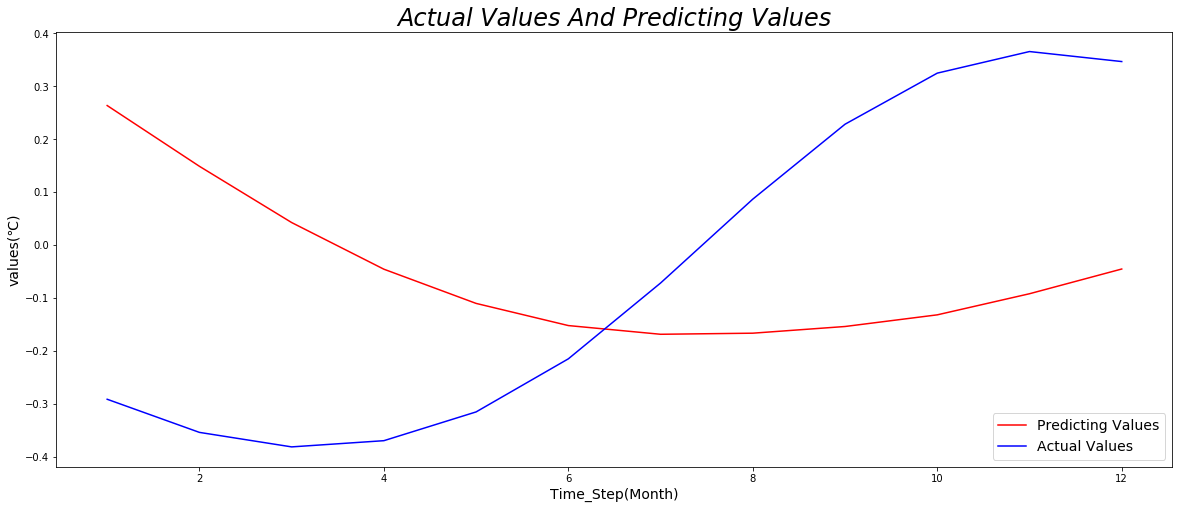

(828,)


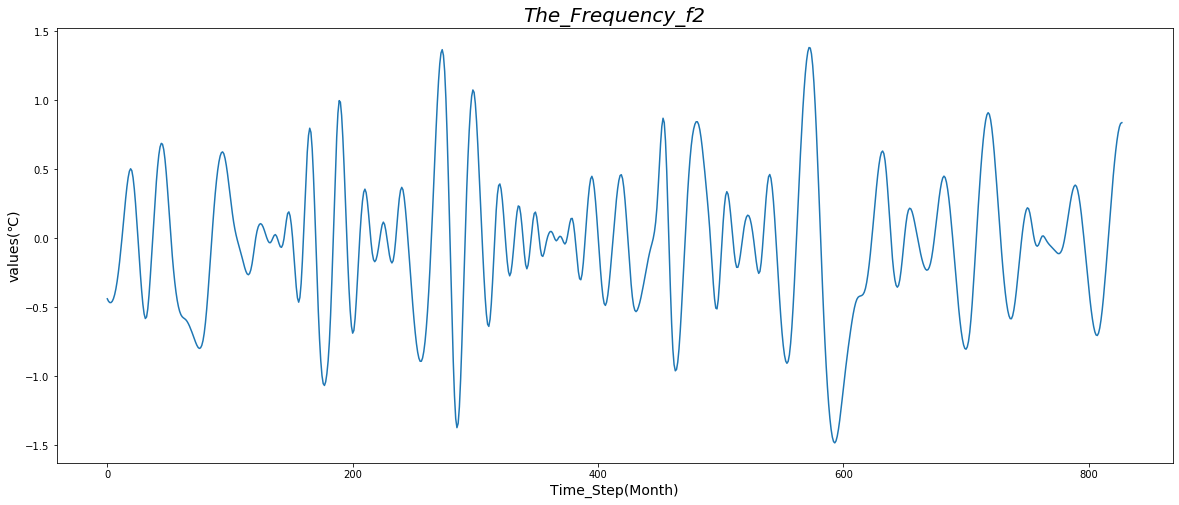

(1, 12, 1)
[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 3s - loss: 0.1922
Epoch 2/200
 - 1s - loss: 0.1500
Epoch 3/200
 - 1s - loss: 0.1381
Epoch 4/200
 - 1s - loss: 0.1302
Epoch 5/200
 - 1s - loss: 0.1225
Epoch 6/200
 - 1s - loss: 0.1206
Epoch 7/200
 - 1s - loss: 0.1134
Epoch 8/200
 - 1s - loss: 0.1075
Epoch 9/200
 - 1s - loss: 0.1021
Epoch 10/200
 - 1s - loss: 0.1059
Epoch 11/200
 - 1s - loss: 0.1000
Epoch 12/200
 - 1s - loss: 0.0982
Epoch 13/200
 - 1s - loss: 0.0972
Epoch 14/200
 - 1s - loss: 0.0983
Epoch 15/200
 - 1s - loss: 0.0928
Epoch 16/200
 - 1s - loss: 0.0949
Epoch 17/200
 - 1s - loss: 0.0955
Epoch 18/200
 - 1s - loss: 0.0879
Epoch 19/200
 - 1s - loss: 0.0897
Epoch 20/200
 - 1s - loss: 0.0966
Epoch 21/200
 - 1s - loss: 0.0955
Epoch 22/200
 - 1s - loss: 0.0871
Epoch 23/200
 - 1s - loss: 0.0860
Epoch 24/200
 - 1s - loss: 0.0856
Epoch 25/200
 - 1s - loss: 0.0942
Epoc

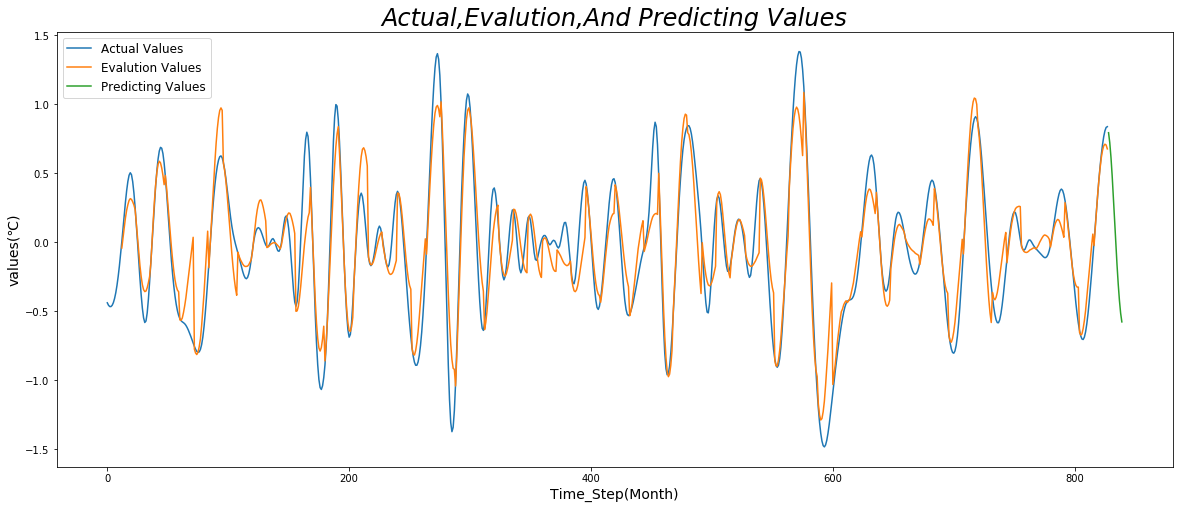

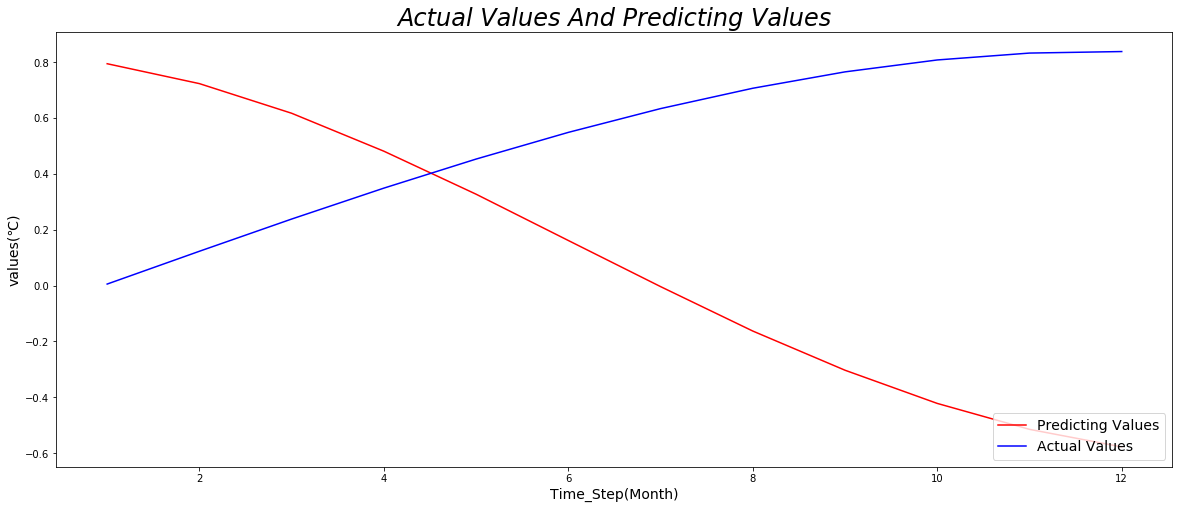

(828,)


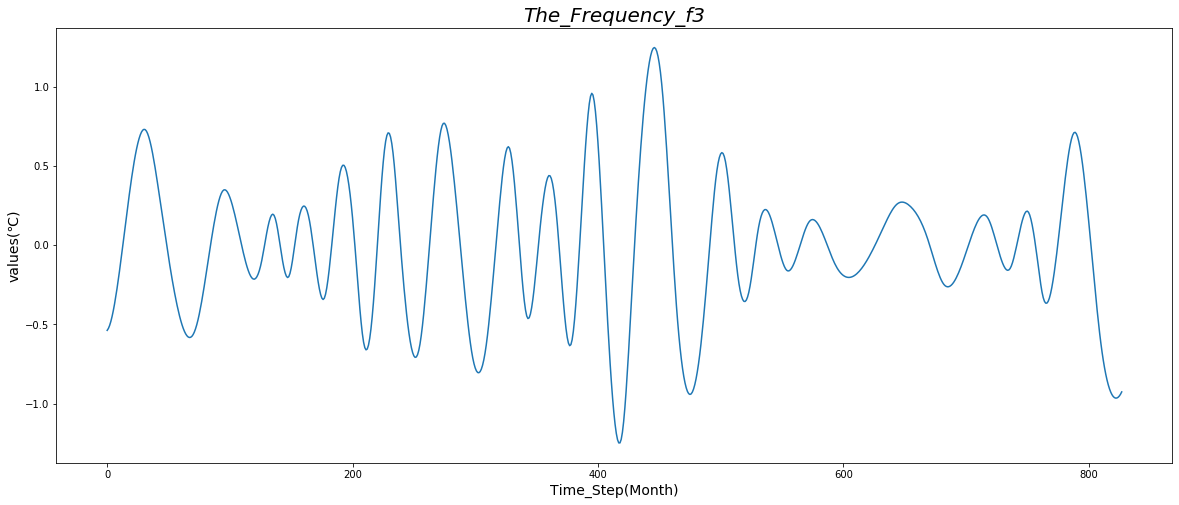

(1, 12, 1)
[-0.88131 -0.90671 -0.92735 -0.94342 -0.95507 -0.96249 -0.96584 -0.96529
 -0.96101 -0.95309 -0.94162 -0.92675]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 3s - loss: 0.1154
Epoch 2/200
 - 1s - loss: 0.0630
Epoch 3/200
 - 1s - loss: 0.0426
Epoch 4/200
 - 1s - loss: 0.0392
Epoch 5/200
 - 1s - loss: 0.0364
Epoch 6/200
 - 1s - loss: 0.0381
Epoch 7/200
 - 1s - loss: 0.0333
Epoch 8/200
 - 1s - loss: 0.0360
Epoch 9/200
 - 1s - loss: 0.0353
Epoch 10/200
 - 1s - loss: 0.0314
Epoch 11/200
 - 1s - loss: 0.0305
Epoch 12/200
 - 1s - loss: 0.0295
Epoch 13/200
 - 1s - loss: 0.0307
Epoch 14/200
 - 1s - loss: 0.0300
Epoch 15/200
 - 1s - loss: 0.0308
Epoch 16/200
 - 1s - loss: 0.0305
Epoch 17/200
 - 1s - loss: 0.0293
Epoch 18/200
 - 1s - loss: 0.0316
Epoch 19/200
 - 1s - loss: 0.0292
Epoch 20/200
 - 1s - loss: 0.0316
Epoch 21/200
 - 1s - loss: 0.0298
Epoch 22/200
 - 1s - loss: 0.0272
Epoch 23/200
 - 1s - loss: 0.0282
Epoch 24/200
 - 1s - loss: 0.0278
Epoch 25/200
 - 1s - loss: 0.0268
Epoch 26/200
 

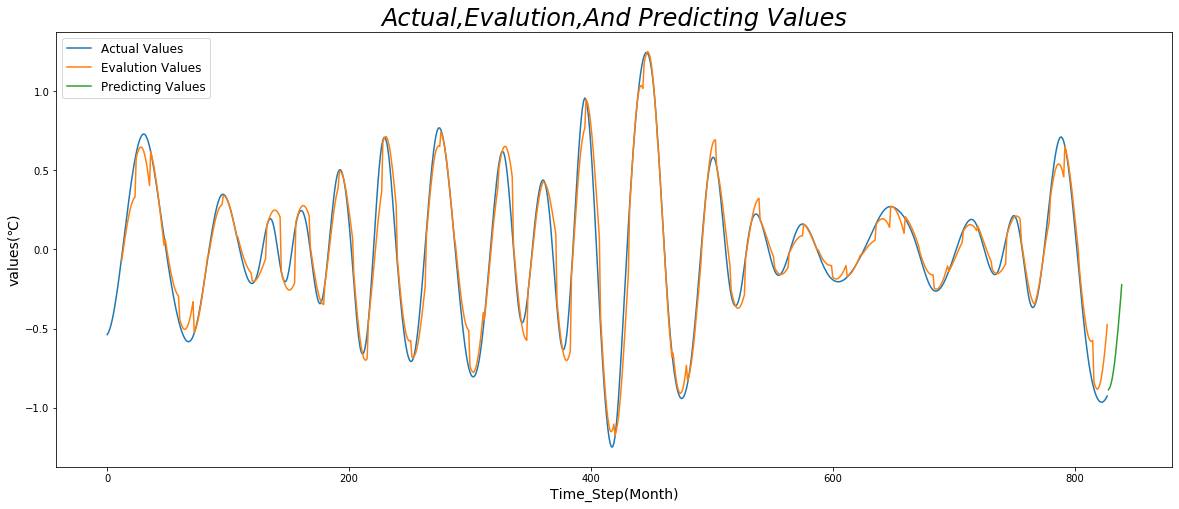

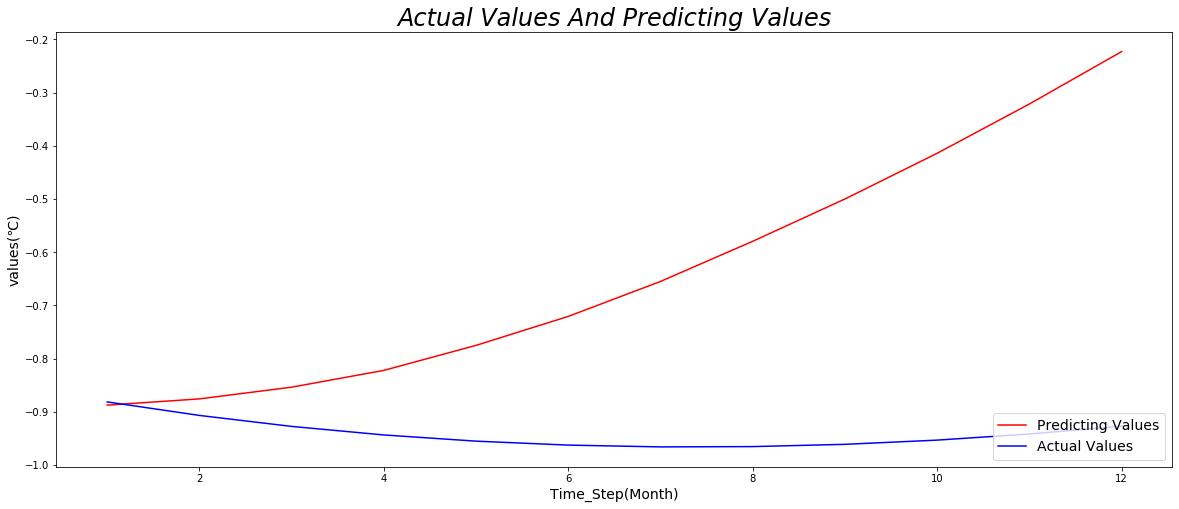

(828,)


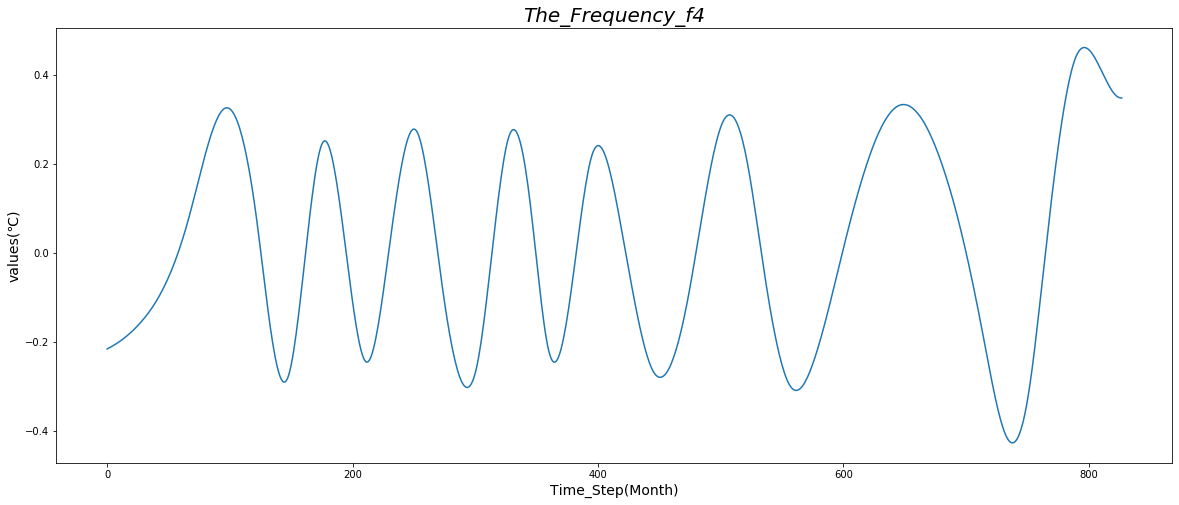

(1, 12, 1)
[0.37911 0.37411 0.36941 0.36506 0.36112 0.35764 0.35466 0.35226 0.35045
 0.34923 0.34856 0.34841]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 4s - loss: 0.0226
Epoch 2/200
 - 1s - loss: 0.0047
Epoch 3/200
 - 1s - loss: 0.0033
Epoch 4/200
 - 1s - loss: 0.0027
Epoch 5/200
 - 1s - loss: 0.0023
Epoch 6/200
 - 1s - loss: 0.0022
Epoch 7/200
 - 1s - loss: 0.0022
Epoch 8/200
 - 1s - loss: 0.0022
Epoch 9/200
 - 1s - loss: 0.0022
Epoch 10/200
 - 1s - loss: 0.0018
Epoch 11/200
 - 1s - loss: 0.0021
Epoch 12/200
 - 1s - loss: 0.0018
Epoch 13/200
 - 1s - loss: 0.0022
Epoch 14/200
 - 1s - loss: 0.0019
Epoch 15/200
 - 1s - loss: 0.0020
Epoch 16/200
 - 1s - loss: 0.0024
Epoch 17/200
 - 1s - loss: 0.0017
Epoch 18/200
 - 1s - loss: 0.0019
Epoch 19/200
 - 1s - loss: 0.0018
Epoch 20/200
 - 1s - loss: 0.0017
Epoch 21/200
 - 1s - loss: 0.0016
Epoch 22/200
 - 1s - loss: 0.0019
Epoch 23/200
 - 1s - loss: 0.0020
Epoch 24/200
 - 1s - loss: 0.0017
Epoch 25/200
 - 1s - loss: 0.0016
Epoch 26/200
 - 1s - loss:

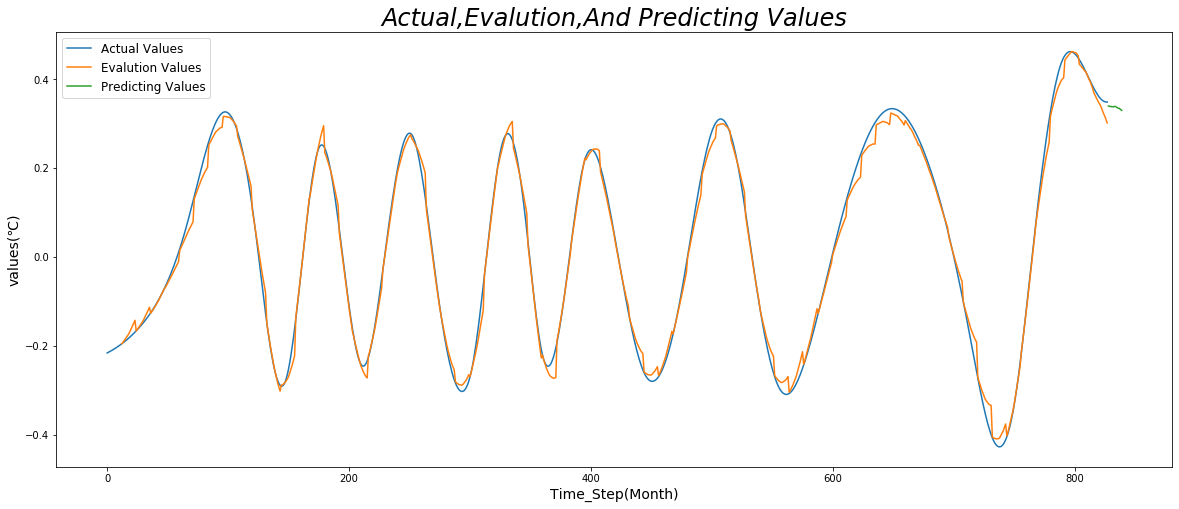

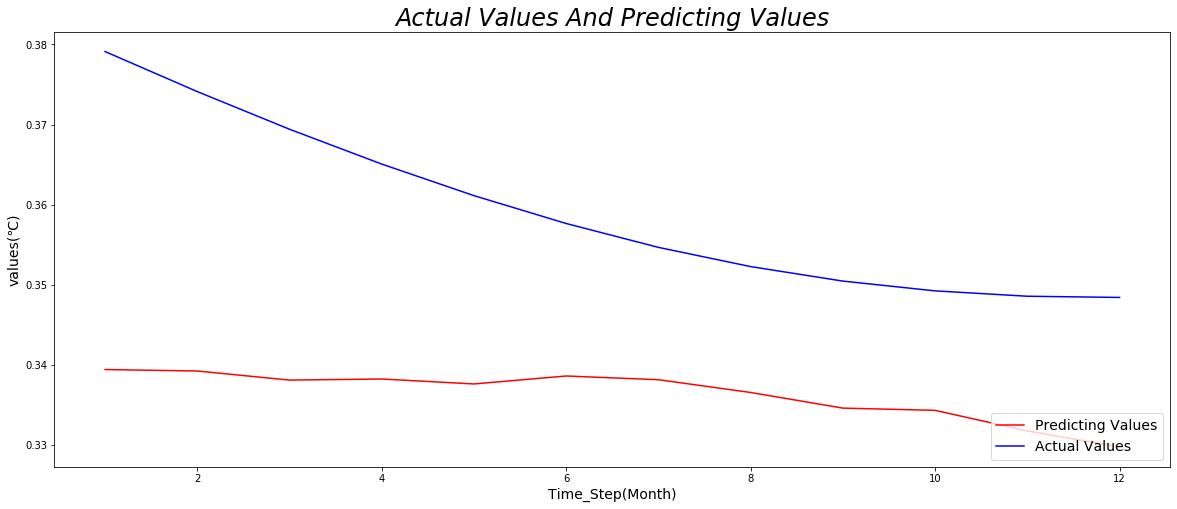

(828,)


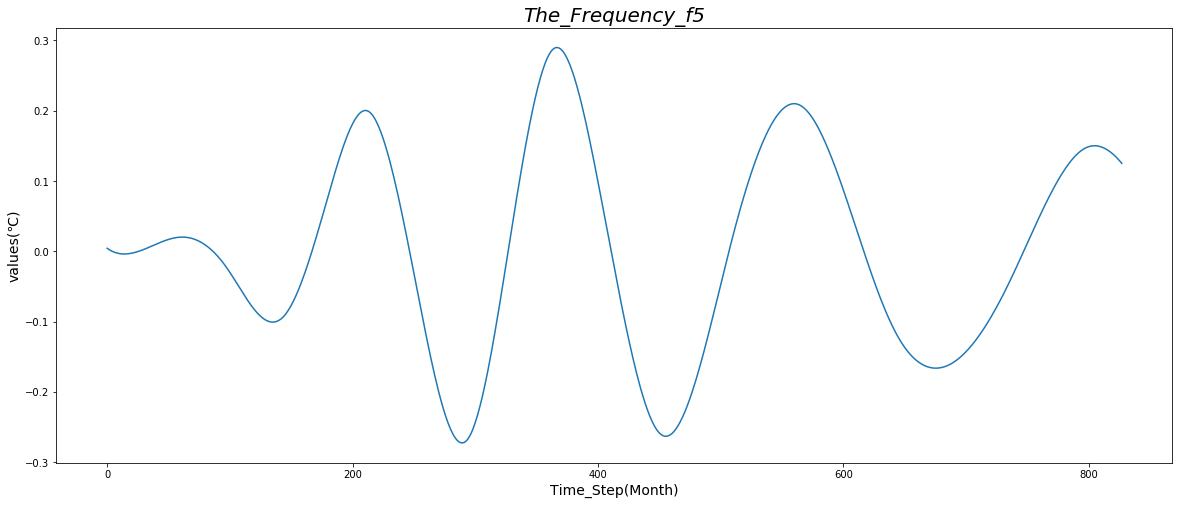

(1, 12, 1)
[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 4s - loss: 0.0063
Epoch 2/200
 - 1s - loss: 0.0019
Epoch 3/200
 - 1s - loss: 7.7167e-04
Epoch 4/200
 - 1s - loss: 3.7271e-04
Epoch 5/200
 - 1s - loss: 3.2186e-04
Epoch 6/200
 - 1s - loss: 3.4692e-04
Epoch 7/200
 - 1s - loss: 3.0429e-04
Epoch 8/200
 - 1s - loss: 2.5792e-04
Epoch 9/200
 - 1s - loss: 3.2411e-04
Epoch 10/200
 - 1s - loss: 3.3968e-04
Epoch 11/200
 - 1s - loss: 3.1996e-04
Epoch 12/200
 - 1s - loss: 2.8309e-04
Epoch 13/200
 - 1s - loss: 2.1097e-04
Epoch 14/200
 - 1s - loss: 2.9802e-04
Epoch 15/200
 - 1s - loss: 2.5979e-04
Epoch 16/200
 - 1s - loss: 2.7723e-04
Epoch 17/200
 - 1s - loss: 2.3836e-04
Epoch 18/200
 - 1s - loss: 2.5226e-04
Epoch 19/200
 - 1s - loss: 2.6522e-04
Epoch 20/200
 - 1s - loss: 2.8077e-04
Epoch 21/200
 - 1s - loss: 2.7137e-04
Epoch 22/200
 - 1s - loss: 2.4470e-04
Epoch 23/200
 - 1s - loss: 2.3963e-04
Epoch 24/2

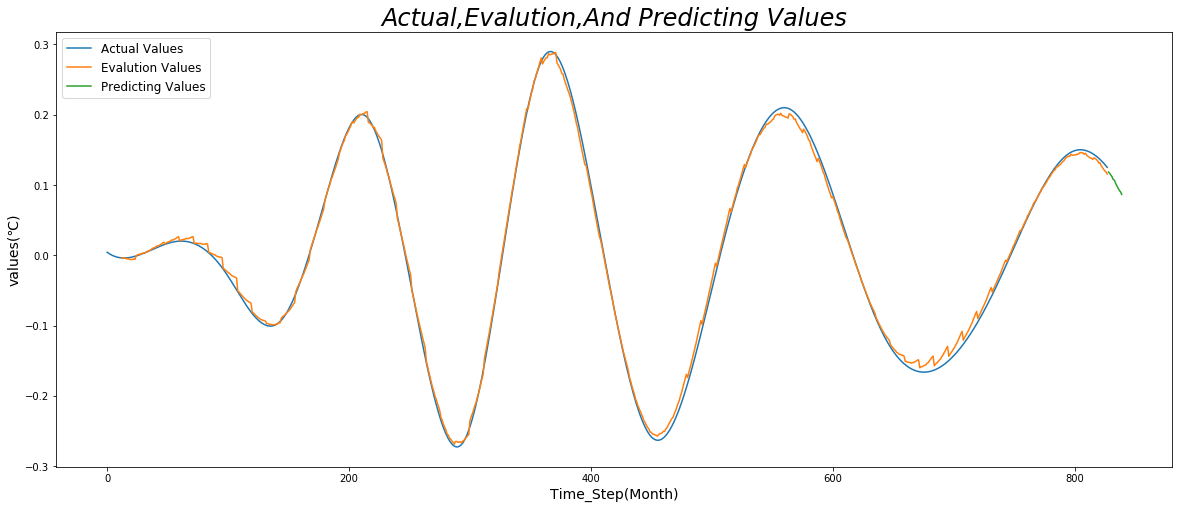

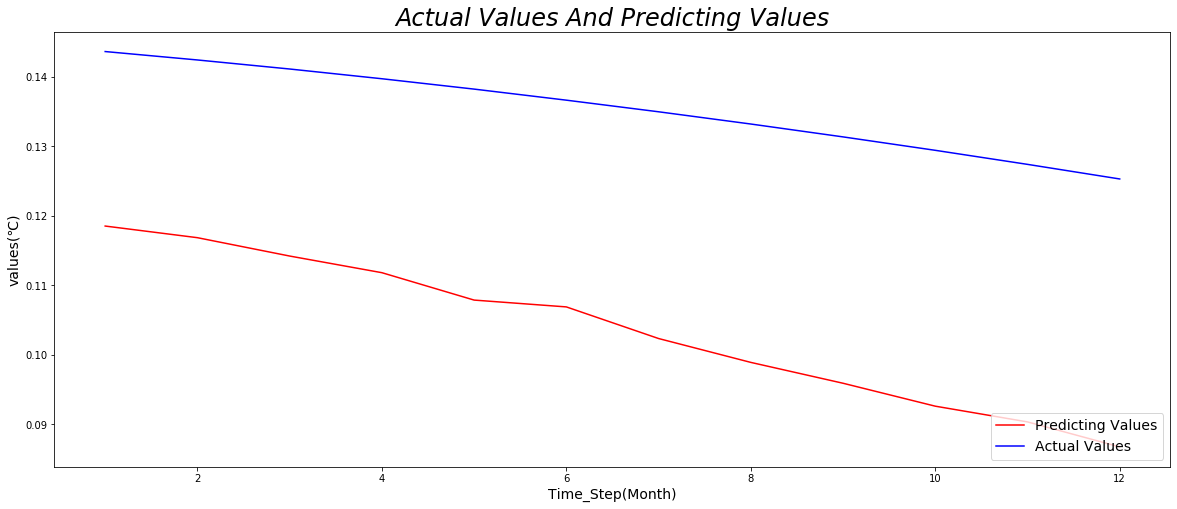

(828,)


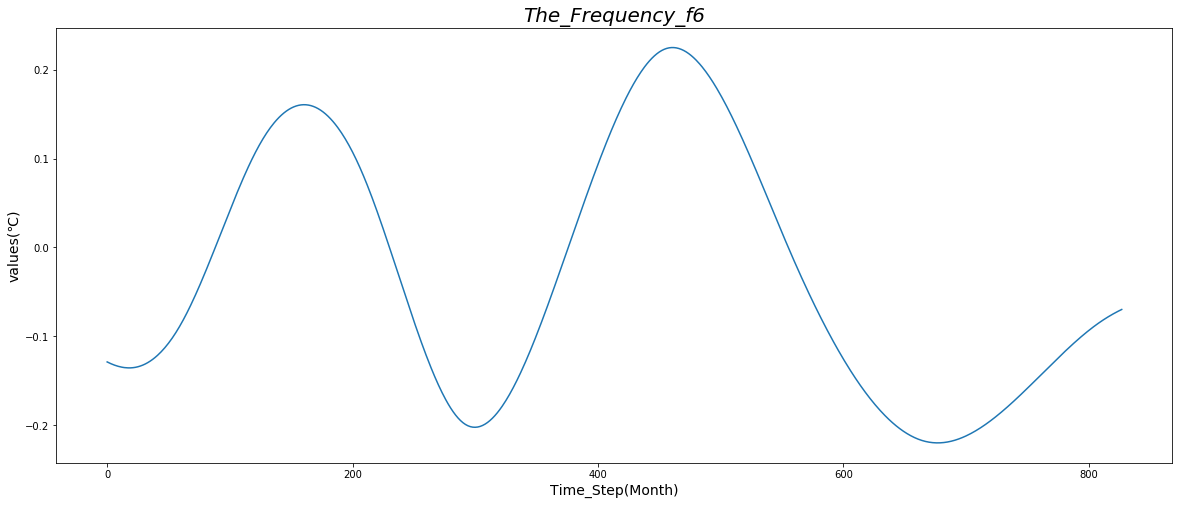

(1, 12, 1)
[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 4s - loss: 0.0056
Epoch 2/200
 - 1s - loss: 0.0011
Epoch 3/200
 - 1s - loss: 8.4758e-04
Epoch 4/200
 - 1s - loss: 6.7038e-04
Epoch 5/200
 - 1s - loss: 4.6426e-04
Epoch 6/200
 - 1s - loss: 5.1397e-04
Epoch 7/200
 - 1s - loss: 3.7065e-04
Epoch 8/200
 - 1s - loss: 2.7067e-04
Epoch 9/200
 - 1s - loss: 2.8437e-04
Epoch 10/200
 - 1s - loss: 3.0323e-04
Epoch 11/200
 - 1s - loss: 2.2862e-04
Epoch 12/200
 - 1s - loss: 2.9008e-04
Epoch 13/200
 - 1s - loss: 2.3394e-04
Epoch 14/200
 - 1s - loss: 2.3038e-04
Epoch 15/200
 - 1s - loss: 2.2341e-04
Epoch 16/200
 - 1s - loss: 1.8668e-04
Epoch 17/200
 - 1s - loss: 1.9862e-04
Epoch 18/200
 - 1s - loss: 1.8897e-04
Epoch 19/200
 - 1s - loss: 2.4432e-04
Epoch 20/200
 - 1s - loss: 2.6760e-04
Epoch 21/200
 - 1s - loss: 2.1269e-04
Epoch 22/200
 - 1s - loss: 2.4287e-04
Epoch 23/200
 - 1s - los

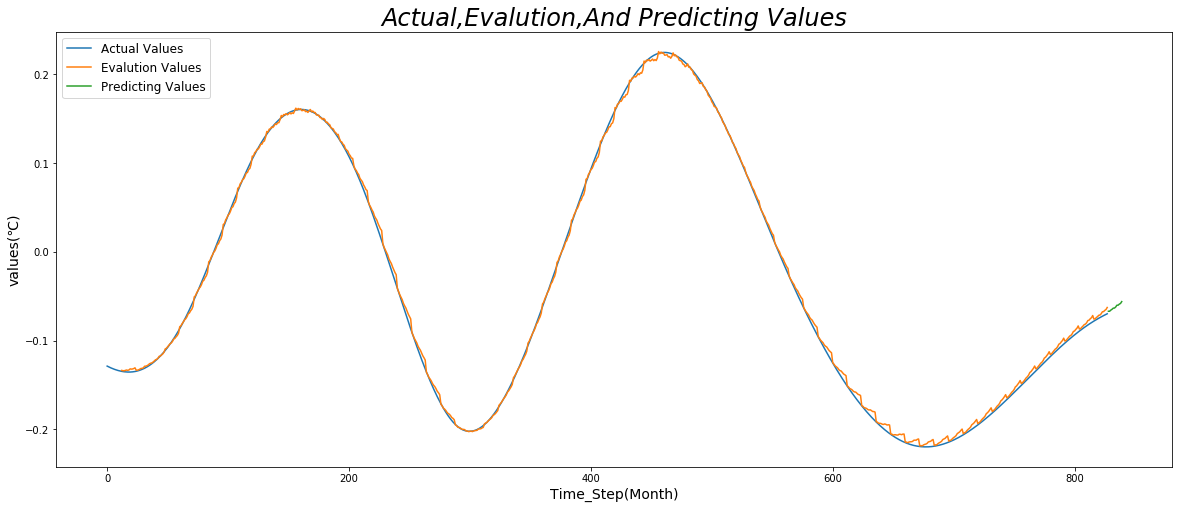

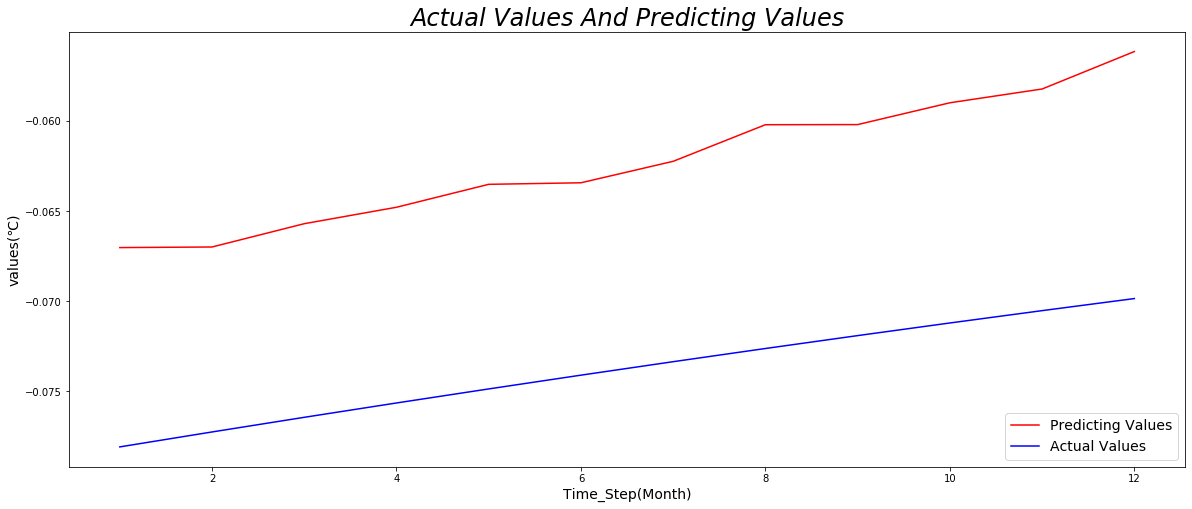

(828,)


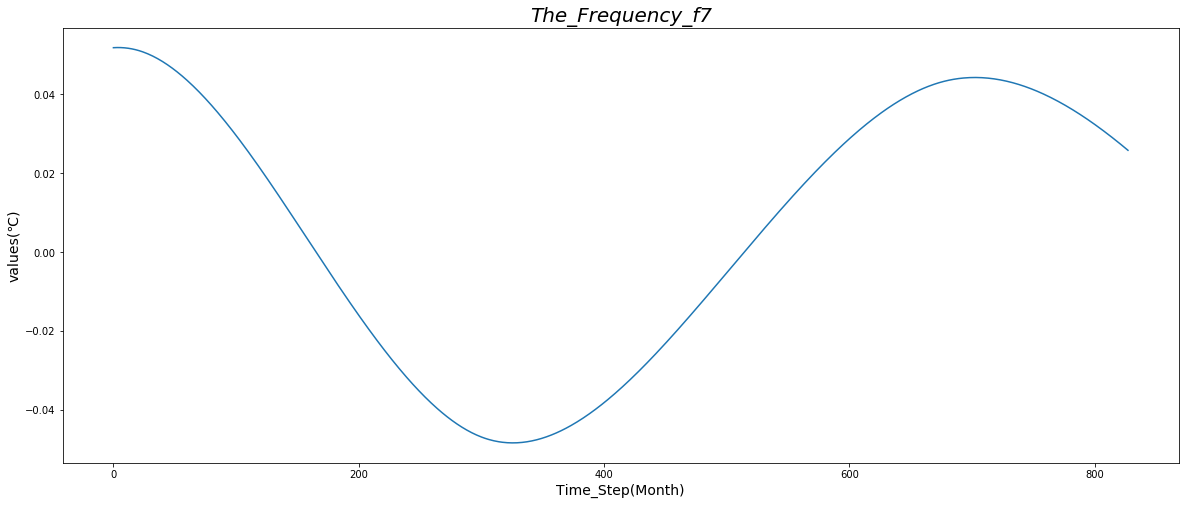

(1, 12, 1)
[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 4s - loss: 3.8607e-04
Epoch 2/200
 - 1s - loss: 4.7499e-05
Epoch 3/200
 - 1s - loss: 3.1995e-05
Epoch 4/200
 - 1s - loss: 2.7977e-05
Epoch 5/200
 - 1s - loss: 2.5756e-05
Epoch 6/200
 - 1s - loss: 3.0583e-05
Epoch 7/200
 - 1s - loss: 2.4423e-05
Epoch 8/200
 - 1s - loss: 2.4070e-05
Epoch 9/200
 - 1s - loss: 1.8835e-05
Epoch 10/200
 - 1s - loss: 2.2705e-05
Epoch 11/200
 - 1s - loss: 1.8991e-05
Epoch 12/200
 - 1s - loss: 1.7841e-05
Epoch 13/200
 - 1s - loss: 1.8193e-05
Epoch 14/200
 - 1s - loss: 1.8855e-05
Epoch 15/200
 - 1s - loss: 2.0874e-05
Epoch 16/200
 - 1s - loss: 1.9912e-05
Epoch 17/200
 - 1s - loss: 2.1235e-05
Epoch 18/200
 - 1s - loss: 1.8657e-05
Epoch 19/200
 - 1s - loss: 1.6455e-05
Epoch 20/200
 - 1s - loss: 1.6599e-05
Epoch 21/200
 - 1s - loss: 2.0152e-05
Epoch 22/200
 - 1s - loss: 1.6130e-05
Epoch 23/200
 - 1s - loss: 1

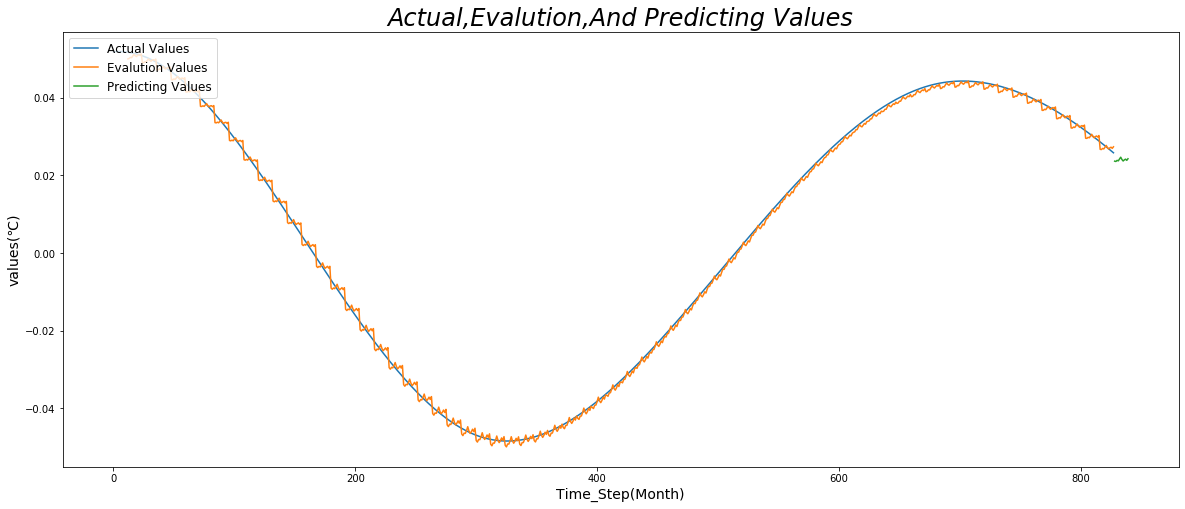

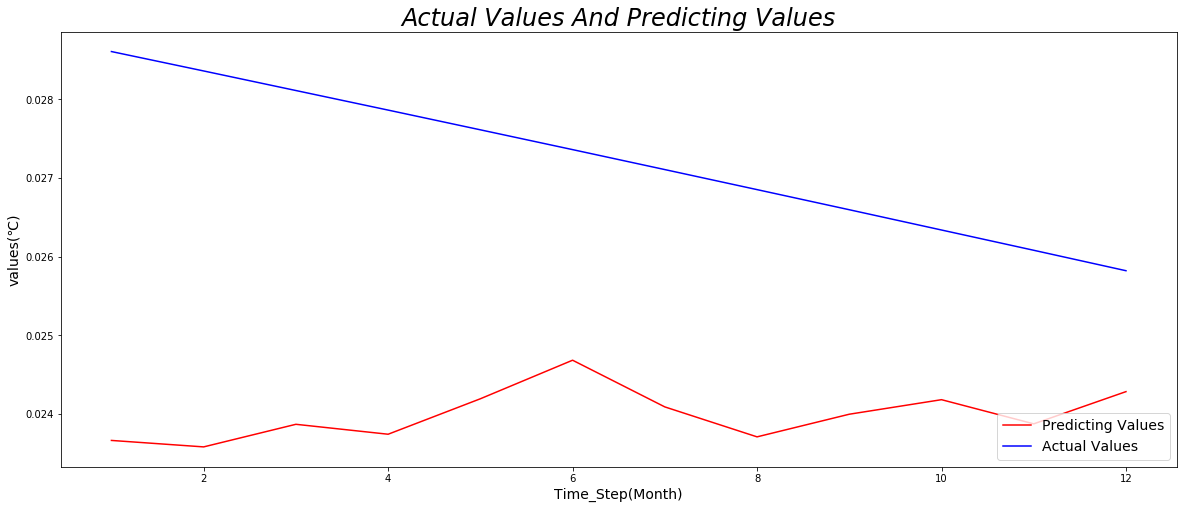

(828,)


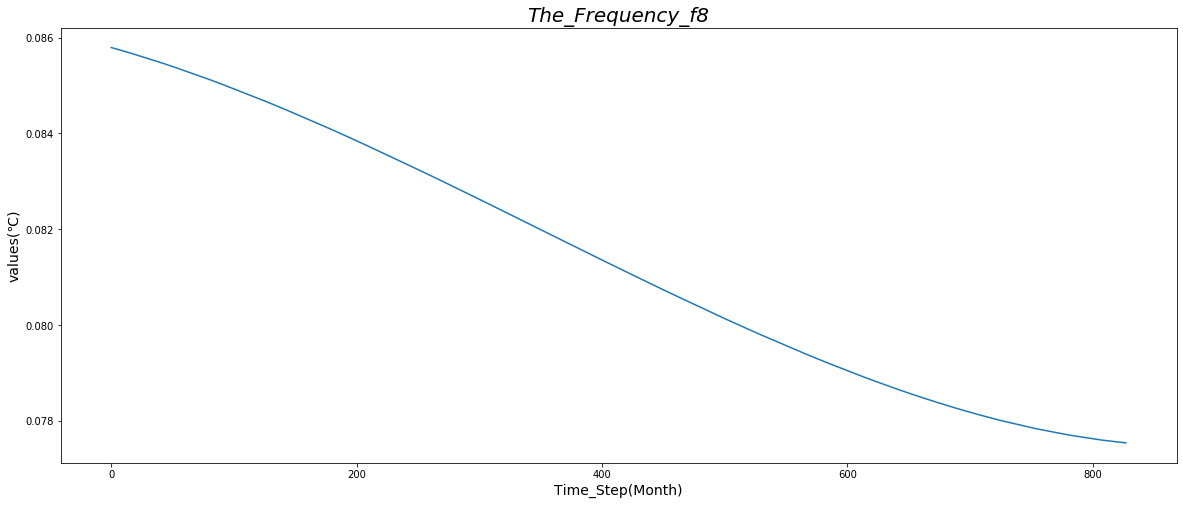

(1, 12, 1)
[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
(804, 12, 1)
(804, 12)
Epoch 1/200
 - 4s - loss: 9.4640e-04
Epoch 2/200
 - 1s - loss: 6.1444e-05
Epoch 3/200
 - 1s - loss: 2.9588e-05
Epoch 4/200
 - 1s - loss: 2.0816e-05
Epoch 5/200
 - 1s - loss: 1.5777e-05
Epoch 6/200
 - 1s - loss: 1.2750e-05
Epoch 7/200
 - 1s - loss: 1.0777e-05
Epoch 8/200
 - 1s - loss: 8.4409e-06
Epoch 9/200
 - 1s - loss: 7.0945e-06
Epoch 10/200
 - 1s - loss: 6.5447e-06
Epoch 11/200
 - 1s - loss: 5.7223e-06
Epoch 12/200
 - 1s - loss: 5.1483e-06
Epoch 13/200
 - 1s - loss: 4.4685e-06
Epoch 14/200
 - 1s - loss: 4.1181e-06
Epoch 15/200
 - 1s - loss: 4.3459e-06
Epoch 16/200
 - 1s - loss: 3.8402e-06
Epoch 17/200
 - 1s - loss: 3.2418e-06
Epoch 18/200
 - 1s - loss: 3.4392e-06
Epoch 19/200
 - 1s - loss: 2.8845e-06
Epoch 20/200
 - 1s - loss: 2.5570e-06
Epoch 21/200
 - 1s - loss: 2.7945e-06
Epoch 22/200
 - 1s - loss: 2.2020e-06
Epoch 23/200
 - 1s - loss: 1

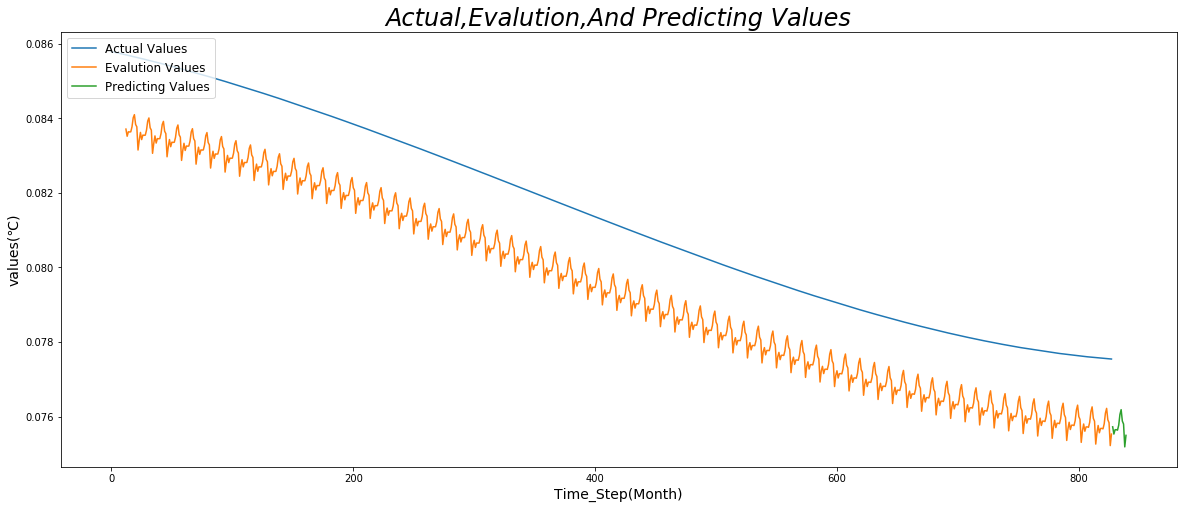

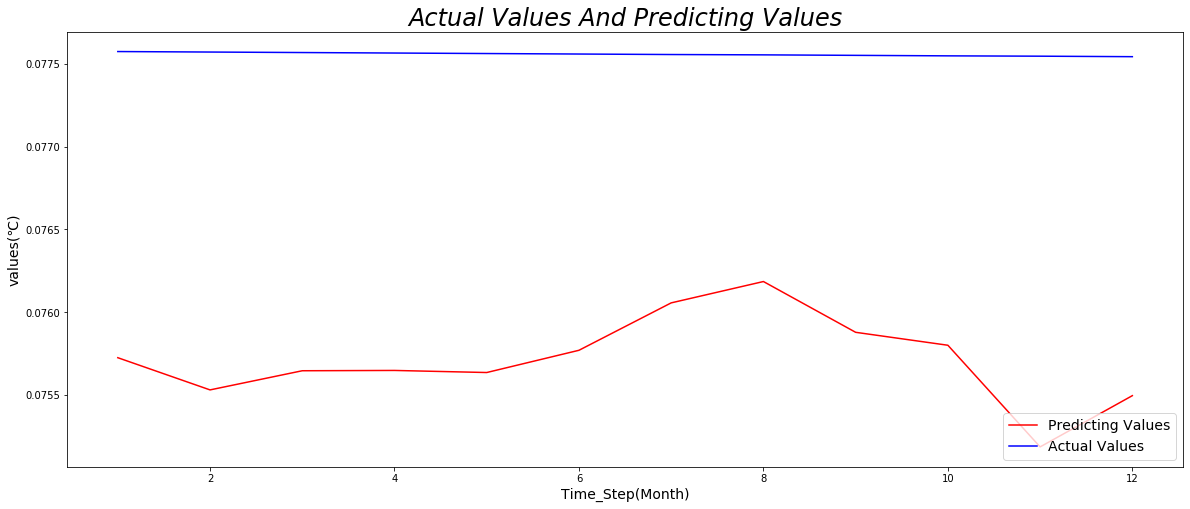

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]

signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_SoloLstm_EMD_prediction')==False):
    os.makedirs('12_months_SoloLstm_EMD_prediction')
        
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_SoloLstm_EMD_prediction/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (test.shape)
    print (test[0].reshape(-1))
    
    n_input = 12
    n_out=12
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    print (train_y.shape)
    
    model=build_model(train_x,train_y,n_input,n_out)
    score, scores,predictions = evaluate_model(train, test, n_input)
    trainPredict = model.predict(train)
    print (predictions.reshape(-1))
    
 
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)[0:-12]

# shift test predictions for plotting
    testPredictPlot = np.zeros(840)
    print (testPredictPlot.shape)
    print (trainPredict.shape)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1)):len(testPredictPlot)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [7]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[0.07572468 0.07553017 0.07564586 0.07564772 0.07563514 0.07576947
 0.07605585 0.07618476 0.07587805 0.07579987 0.07518592 0.07549543]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.12738, 0.12528]), array([-0.078087,

In [8]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
-----------------------------------
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
-----------------------------------
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70

In [9]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i]))
    predicted_values = np.add(predicted_values, prediction_in_one[i])
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.041682   -0.07287828 -0.03009706  0.00186203  0.02867441  0.04990342
  0.05643009  0.02911062  0.00226607  0.00124596  0.01784869  0.01941493]
[-0.041682   -0.07287828 -0.03009706  0.00186203  0.02867441  0.04990342
  0.05643009  0.02911062  0.00226607  0.00124596  0.01784869  0.01941493]
the 1 frequence:
predicted_value:[ 0.26336786  0.1486268   0.04236414 -0.045748   -0.11037342 -0.15223025
 -0.16868608 -0.16663072 -0.15399957 -0.13198523 -0.09211895 -0.04541719]
[ 0.22168586  0.07574853  0.01226708 -0.04388597 -0.08169901 -0.10232683
 -0.11225598 -0.1375201  -0.1517335  -0.13073927 -0.07427026 -0.02600226]
the 2 frequence:
predicted_value:[ 0.79446393  0.7232233   0.6171521   0.4812958   0.32732466  0.16157757
 -0.0034784  -0.16258495 -0.30285916 -0.4216898  -0.5145205  -0.57732624]
[ 1.01614979  0.79897185  0.62941918  0.43740983  0.24562565  0.05925073
 -0.11573438 -0.30010504 -0.45459266 -0.55242908 -0.588

[[-0.9]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.1]
 [ 0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [ 0.7]
 [ 0.9]
 [ 0.8]]
[ 0.61905206  0.4115035   0.261914    0.09999985 -0.04762822 -0.17882729
 -0.29223554 -0.40439983 -0.48433958 -0.49855177 -0.44724944 -0.36614515]


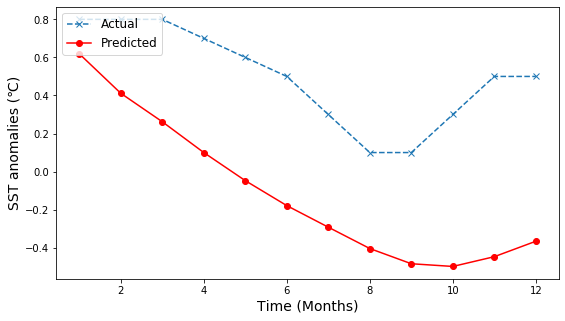

In [10]:
print (round_true_values)
print (predicted_values)

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)

actual_values_2019=[0.8,0.8,0.8,0.7,0.6,0.5,0.3,0.1,0.1,0.3,0.5,0.5]
plt.plot(index_start,np.array(actual_values_2019).reshape(-1),marker="x",linestyle='--',label='Actual')

plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_the_final_predict_real_result.png')
plt.show() 
 